In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
import scipy.stats as stats 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from statsmodels.formula.api import glm
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Data import and aggregation steps: 

    I.	Collate the information specific to flights, airports (like type of airport, elevation etc) and runway(length_ft, width_ft, surface etc.). Get all those fields in single dataset which you believe may impact the delay. 

In [2]:
address = '/home/labsuser/Capstone_3'

In [3]:
airlines = pd.read_excel(address + '/Airlines.xlsx')
airports = pd.read_excel(address + '/airports.xlsx')
runways = pd.read_excel(address + '/runways.xlsx')

In [4]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [5]:
airports.head(2)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN


In [6]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


In [7]:
airports.head(2)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN


In [8]:
airport_run = pd.merge(airports, runways, left_on = 'ident', right_on = 'airport_ident', how = "left")
airport_run.head(2)

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,...,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
count_runway = airport_run.groupby('airport_ident')[['id_y']].count().sort_values(by = 'id_y', ascending = False).reset_index()
count_runway.head(2)

,airport_ident,id_y
0,KORD,11
1,KNHU,10


In [10]:
air_run = pd.merge(airports, count_runway, how = 'left', left_on = 'ident', right_on = 'airport_ident')[['iata_code', 'type', 'elevation_ft','id_y']]
air_run.rename(columns = {'id_y': 'runway_count'}, inplace = True)
air_run.head(2)

,iata_code,type,elevation_ft,runway_count
0,NaN,heliport,11.0,1.0
1,NaN,small_airport,3435.0,NaN


In [11]:
air_run.dropna().to_csv('run_2.csv', index = False)

In [12]:
airlines.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1


In [13]:
combined_data = pd.merge(airlines, air_run, how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')

new_names = list(combined_data[air_run.columns].columns + '_source_airport')
old_names = list(combined_data[air_run.columns].columns)

combined_data.rename(columns = {old:new for old,new in zip(old_names, new_names)}, inplace = True)
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0


In [14]:
combined_data.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport'],
      dtype='object')

In [15]:
combined_data = pd.merge(combined_data, air_run, how = 'left', left_on = 'AirportTo', right_on = 'iata_code')


In [16]:
new_names = list(combined_data[air_run.columns].columns + '_dest_airport')
old_names = list(combined_data[air_run.columns].columns)
combined_data.rename(columns = {old:new for old,new in zip(old_names, new_names)}, inplace = True)
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code_dest_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0


In [17]:
# drop iata_code columns 
combined_data.drop(columns =  list(combined_data.columns[combined_data.columns.str.startswith('iata_code')]), inplace = True)

## II.	Different airline companies may perform differently in terms of on time arrival. The performance may depend on the experience of the airline company. Pull the information specific to different airlines from the Wikipedia page https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States. Use web scaping to fetch the information about how long the airlines has been in the business. 

In [18]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States').text
soup = BeautifulSoup(website_url,'lxml')
My_table = soup.findAll("table",{"class":"wikitable"})

In [19]:
len(My_table) 

7

In [20]:
airlines_wiki_list = []
for tab in My_table:
    temp = pd.read_html(str(tab))
    temp = pd.DataFrame(temp[0])
    airlines_wiki_list.append(temp)

In [21]:
airlines_wiki = pd.concat(airlines_wiki_list)

III.	Get all the information pulled so far in one table.

In [22]:
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0


### finding the year founded of airlines

In [23]:
airlines_founded = pd.merge(combined_data[['Airline']].drop_duplicates(),airlines_wiki[['IATA', 'Founded']].drop_duplicates(), 
         how = 'left', left_on = 'Airline', right_on = 'IATA')

In [24]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [25]:
# will fill in missing values later

IV.	Look into Wikipedia page:
 https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States
Total passenger traffic may also contribute to the delay of flights. The term hub is used to identify busy commercial airports. Large hubs are the airports that each account for at least one percent of total U.S. passenger enplanements. Medium hubs are defined as airports that each account for between 0.25 percent and 1 percent of the total passenger enplanements.

Pull passenger traffic data using web scraping and collate in a table. 

In [26]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States').text
soup = BeautifulSoup(website_url,'lxml')
My_table = soup.findAll("table",{"class":"wikitable"})

In [27]:
hub_data = {}
i = 0
for tab in My_table:
    hub_data[i] = pd.read_html(str(tab))
    hub_data[i] = pd.DataFrame(hub_data[i][0])
    i +=1

## We need only hub data hence first two table

In [28]:
large_hub = hub_data[0].copy()
med_hub = hub_data[1].copy()

In [29]:
large_hub.insert(loc =1, column= 'Hub_type', value = 'large')
med_hub.insert(loc =1, column= 'Hub_type', value = 'medium')

In [30]:
# before combinig lets work with column names 

In [31]:
# remove any special characters or things in bracket

In [32]:
# remove refrences from brackets 
column_temp = large_hub.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
large_hub.columns = column_temp
large_hub.columns

Index(['rank', 'hub_type', 'airports', 'iatacode', 'major_cities_served',
       'state', 'data_2021', 'data_2020', 'data_2019', 'data_2018',
       'data_2017', 'data_2016', 'data_2015', 'data_2014', 'data_2013',
       'data_2012', 'data_2011'],
      dtype='object')

In [33]:
# remove refrences from brackets 
column_temp = med_hub.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
med_hub.columns = column_temp
med_hub.columns

Index(['rank', 'hub_type', 'airports', 'iatacode', 'city_served', 'state',
       'data_2020', 'data_2019', 'data_2018', 'data_2017', 'data_2016',
       'data_2015', 'data_2014'],
      dtype='object')

In [34]:
large_hub.rename(columns = {'major_cities_served':'city_served'}, inplace = True)

In [35]:
final_hub_data = pd.concat([large_hub, med_hub])

In [36]:
final_hub_data.head(2)

,rank,hub_type,airports,iatacode,city_served,state,data_2021,data_2020,data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,data_2013,data_2012,data_2011
0,1,large,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,36676010.0,20559866,53505795,51865797.0,50251964.0,50501858.0,49340732.0,46604273.0,45308407.0,45798928.0,44414121.0
1,2,large,Dallas/Fort Worth International Airport,DFW,Dallas & Ft. Worth,TX,30005266.0,18593421,35778573,32821799.0,31816933.0,31283579.0,31589839.0,30804567.0,29038128.0,28022904.0,27518358.0


In [37]:
final_hub_data.data_2019.isnull().sum()

0

In [38]:
combined_data_pax = pd.merge(combined_data, final_hub_data[['iatacode', 'data_2019']],how = 'left' , left_on = 'AirportFrom', right_on = 'iatacode')

In [39]:
combined_data_pax.rename(columns = {'iatacode': 'iatacode_source' ,'data_2019': 'data_2019_source_airport'}, inplace = True)

In [40]:
combined_data_pax = pd.merge(combined_data_pax, final_hub_data[['iatacode', 'data_2019']],how = 'left' , left_on = 'AirportTo', right_on = 'iatacode')

In [41]:
combined_data_pax.rename(columns = {'iatacode': 'iatacode_dest' ,'data_2019': 'data_2019_dest_airport'}, inplace = True)

In [42]:
combined_data_pax = combined_data_pax.loc[:,~combined_data_pax.columns.str.startswith('iatacode')].copy()

In [43]:
combined_data_pax

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,22433552.0,24199688.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,42939104.0,35778573.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,27779230.0,35778573.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,2713843.0,25001762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518551,539377,B6,717,JFK,SJU,5,1439,220,1,large_airport,13.0,4.0,large_airport,9.0,2.0,31036655.0,4590117.0
518552,539378,B6,739,JFK,PSE,5,1439,223,1,large_airport,13.0,4.0,medium_airport,29.0,1.0,31036655.0,NaN
518553,539379,CO,178,OGG,SNA,5,1439,326,0,medium_airport,54.0,2.0,large_airport,56.0,2.0,3791807.0,5153276.0
518554,539382,UA,78,HNL,SFO,5,1439,313,1,large_airport,13.0,6.0,large_airport,13.0,4.0,9988678.0,27779230.0


## addd founded column

In [44]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [45]:
combined_data_pax = pd.merge(combined_data_pax, airlines_founded[['Airline', 'Founded']], on = 'Airline')

In [46]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,NaN
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,NaN


## 1.	Check the missing values in each field. Perform missing value treatment. Justify your actions

### combined pax

In [47]:
combined_data_pax.isna().sum().sort_values(ascending = False)

data_2019_source_airport       85894
data_2019_dest_airport         85841
Founded                        83601
runway_count_dest_airport         31
elevation_ft_dest_airport         31
type_dest_airport                 31
runway_count_source_airport       31
elevation_ft_source_airport       31
type_source_airport               31
AirportTo                          0
Airline                            0
Flight                             0
AirportFrom                        0
Delay                              0
DayOfWeek                          0
Time                               0
Length                             0
id                                 0
dtype: int64

#### for type runway count and elevation lets get the airports for which information is missing

In [48]:
combined_data_pax[combined_data_pax.type_source_airport.isna()].AirportFrom.unique()

array(['CYS'], dtype=object)

In [49]:
combined_data_pax[combined_data_pax.type_dest_airport.isna()].AirportTo.unique()

array(['CYS'], dtype=object)

As we see information for only CYS is missing Lets check for this information using data dictionary and match the description and name of the airport to fetch information 

In [50]:
airport_dict = pd.read_excel(address + '/Data Dictionary.xlsx', sheet_name = 'airlines',header = 29, usecols = [0,1])
airport_dict.head(2)

,Aiport ID,Description
0,ABE,RAF Calveley
1,ABE,Bisho Airport


In [51]:
name = airport_dict[airport_dict['Aiport ID'] == 'CYS'].Description.values[0]
name.lower()

'cheyenne regional jerry olson field'

In [52]:
air_miss = airports.loc[name.lower() == airports.name.str.lower(), ['ident', 'name', 'iata_code', 'type', 'elevation_ft']]

In [53]:
air_miss_comb = pd.merge(air_miss, runways[['airport_ident', 'id']], how = 'left', left_on = 'ident', right_on = 'airport_ident')
runway_count_miss = air_miss_comb.groupby('ident')[['id']].count().sort_values(by = 'id', ascending = False).reset_index()
runway_count_miss

,ident,id
0,KCYS,2


In [54]:
air_miss_data = pd.merge(air_miss,runway_count_miss ).rename(columns = {'id' : 'runway_count'})[['iata_code', 'type', 'elevation_ft', 'runway_count']]

In [55]:
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'type_source_airport'] = air_miss_data.type.values[0]
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'elevation_ft_source_airport'] = air_miss_data.elevation_ft.values[0]
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'runway_count_source_airport'] = air_miss_data.runway_count.values[0]

In [56]:
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'type_dest_airport'] = air_miss_data.type.values[0]
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'elevation_ft_dest_airport'] = air_miss_data.elevation_ft.values[0]
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'runway_count_dest_airport'] = air_miss_data.runway_count.values[0]

In [57]:
combined_data_pax.isna().sum().sort_values(ascending = False)

data_2019_source_airport       85894
data_2019_dest_airport         85841
Founded                        83601
Length                             0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Delay                              0
type_source_airport                0
elevation_ft_source_airport        0
runway_count_source_airport        0
type_dest_airport                  0
elevation_ft_dest_airport          0
runway_count_dest_airport          0
id                                 0
dtype: int64

In [58]:
airline_dict = pd.read_excel(address + '/Data Dictionary.xlsx', sheet_name = 'airlines',header = 10, usecols = [0,1])
airline_dict.head(2)

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta


In [59]:
miss_founded = combined_data_pax[combined_data_pax.Founded.isna()].Airline.unique()
print(airline_dict[airline_dict['Airlines ID'].isin( ['EV', 'CO', 'US'])])

  Airlines ID                        Description
5          US  PSA (initially US Airway Express)
7          EV                         ExpressJet
9          CO     United Airlines (initially CO)


In [60]:
miss_val = {'US' : 1967, 'CO' : 1934, 'EV' : 1986}
for aline in miss_founded:
    combined_data_pax.loc[(combined_data_pax.Founded.isna()) & 
                      (combined_data_pax.Airline == aline), 'Founded'] = miss_val[aline] 

In [61]:
(combined_data_pax.isna().sum().sort_values(ascending = False)/combined_data_pax.shape[0])*100

data_2019_source_airport       16.564074
data_2019_dest_airport         16.553853
Founded                         0.000000
Length                          0.000000
Airline                         0.000000
Flight                          0.000000
AirportFrom                     0.000000
AirportTo                       0.000000
DayOfWeek                       0.000000
Time                            0.000000
Delay                           0.000000
type_source_airport             0.000000
elevation_ft_source_airport     0.000000
runway_count_source_airport     0.000000
type_dest_airport               0.000000
elevation_ft_dest_airport       0.000000
runway_count_dest_airport       0.000000
id                              0.000000
dtype: float64

For missing pax data use median value based on 'type' of airport

In [62]:
combined_data_pax.groupby('type_source_airport')[['data_2019_source_airport']].median()

,data_2019_source_airport
type_source_airport,
large_airport,21905309.0
medium_airport,3323614.0
small_airport,NaN


In [63]:
med_val = combined_data_pax.groupby('type_source_airport')[['data_2019_source_airport']].median()
med_val

,data_2019_source_airport
type_source_airport,
large_airport,21905309.0
medium_airport,3323614.0
small_airport,NaN


In [64]:
for typ in combined_data_pax.type_source_airport.unique():
      combined_data_pax.loc[(combined_data_pax.type_source_airport == typ)& (combined_data_pax.data_2019_source_airport.isna()),
                      'data_2019_source_airport'] = med_val.loc[typ].values[0]

In [65]:
med_val_dest = combined_data_pax.groupby('type_dest_airport')[['data_2019_dest_airport']].median()
med_val_dest

,data_2019_dest_airport
type_dest_airport,
large_airport,21905309.0
medium_airport,3323614.0
small_airport,NaN


In [66]:
for typ in combined_data_pax.type_source_airport.unique():
      combined_data_pax.loc[(combined_data_pax.type_dest_airport == typ)& (combined_data_pax.data_2019_dest_airport.isna()),
                      'data_2019_dest_airport'] = med_val.loc[typ].values[0]

In [67]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0


In [68]:
(combined_data_pax.isna().sum().sort_values(ascending = False)/combined_data_pax.shape[0])*100

data_2019_source_airport       0.226205
data_2019_dest_airport         0.224855
Founded                        0.000000
Length                         0.000000
Airline                        0.000000
Flight                         0.000000
AirportFrom                    0.000000
AirportTo                      0.000000
DayOfWeek                      0.000000
Time                           0.000000
Delay                          0.000000
type_source_airport            0.000000
elevation_ft_source_airport    0.000000
runway_count_source_airport    0.000000
type_dest_airport              0.000000
elevation_ft_dest_airport      0.000000
runway_count_dest_airport      0.000000
id                             0.000000
dtype: float64

### Since % of values missing is 0.2% we can simply eliminate these rows

## 2.	Perform data visualization and share your insights related to following aspects:
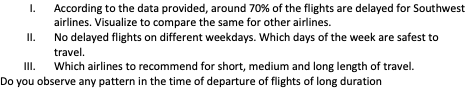

In [69]:
# get id for "southwest Airlines"
id_airline = airline_dict.loc[airline_dict['Description'].str.strip().str.lower() == 'southwest', 'Airlines ID'].values[0]

In [70]:
round(combined_data_pax[combined_data_pax.Airline == id_airline].Delay.sum()/
      combined_data_pax[combined_data_pax.Airline == id_airline].Delay.size*100)

70

In [71]:
def percent_Delay(x):
    return round(x.sum()/x.size * 100,2)

In [72]:
delay_perc = combined_data_pax.groupby('Airline')['Delay'].agg(percent_Delay)
delay_perc = delay_perc.reset_index()

In [73]:
plot_data = pd.merge(delay_perc, airline_dict, left_on = 'Airline', 
                     right_on = 'Airlines ID', how = 'left')[['Airline', 'Description', 'Delay']]
plot_data

,Airline,Description,Delay
0,9E,Endeavor,39.77
1,AA,American Airlines,38.85
2,AS,Alaska,33.93
3,B6,Jetblue,46.70
4,CO,United Airlines (initially CO),56.62
5,DL,Delta,45.05
6,EV,ExpressJet,40.22
7,F9,Frontier,44.90
8,HA,Hawaiian,32.02
9,MQ,Envoy,34.81


findfont: Font family ['times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


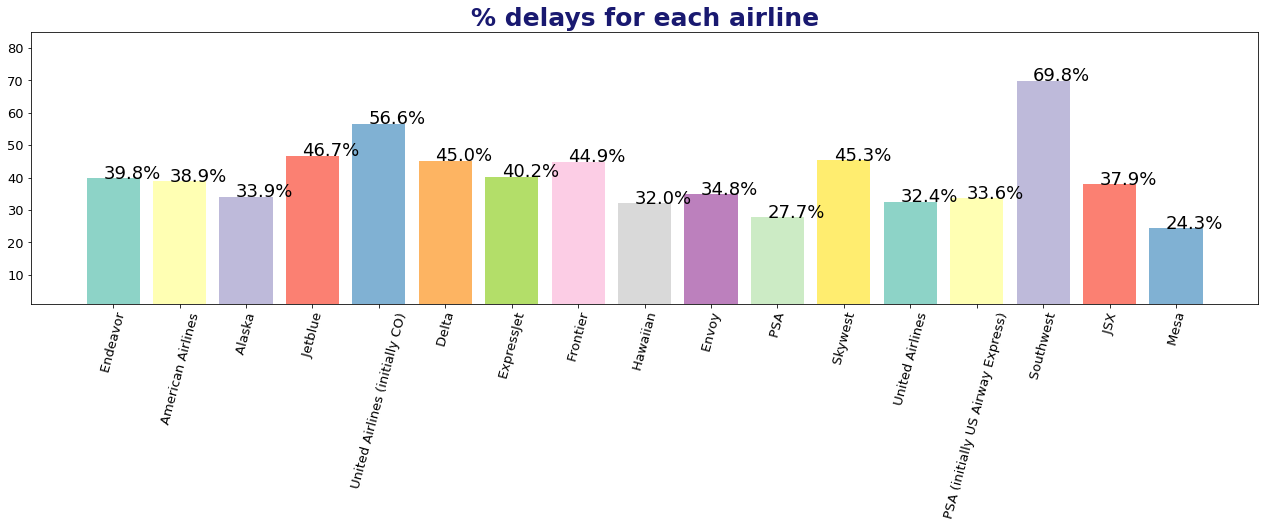

In [74]:
plt.figure(figsize = (22,5))
plt.bar(plot_data.Description, height =  plot_data.Delay, color = plt.get_cmap('Set3').colors)
for v, idx in zip(plot_data.Delay.values,plot_data.index ):
    plt.annotate('{:.1f}%'.format(v), xy = (idx-0.15, v), size = 18, family = 'times')
plt.ylim(1,85)
plt.xticks(size = 13, rotation = 75)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

## 
    II.	No delayed flights on different weekdays. Which days of the week are safest to travel.

In [75]:
combined_data_pax.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2713843.0,25001762.0,1934.0
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,24728361.0,21905309.0,1934.0
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2723002.0,21905309.0,1934.0


In [76]:
delay_perc_weekday = combined_data_pax.groupby('DayOfWeek')['Delay'].agg(percent_Delay)
delay_perc_weekday

DayOfWeek
1    47.22
2    45.21
3    47.58
4    45.78
5    42.56
6    40.56
7    45.77
Name: Delay, dtype: float64

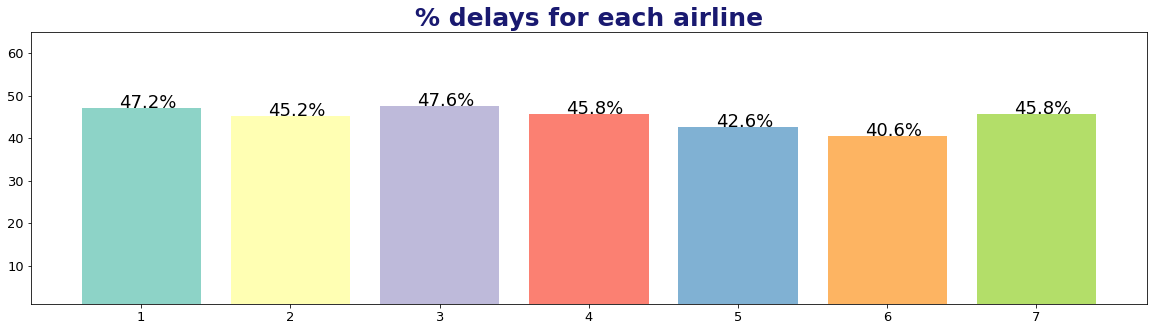

In [77]:
plt.figure(figsize = (20,5))
plt.bar(delay_perc_weekday.index, height =  delay_perc_weekday.values, color = plt.get_cmap('Set3').colors)
for v, idx in zip(delay_perc_weekday.values, range(1, len(delay_perc_weekday.index)+1)):
    # print(v, idx)
    plt.annotate('{:.1f}%'.format(v), xy = (idx-0.15, v), size = 18, family = 'times')
plt.ylim(1,65)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

##
    III.	Which airlines to recommend for short, medium and long length of travel.

In [78]:
duration_data = combined_data_pax[['Airline', 'Length', 'Delay']].copy()

In [79]:
duration_data['duration'] = pd.cut(duration_data.Length, 3, labels = ['short', 'medium', 'long'])
duration_data_grp = duration_data.groupby(['Airline','duration'])['Delay'].agg(
    percent_Delay).reset_index().pivot(index = 'Airline', 
                                       columns = 'duration').fillna(0)['Delay']
duration_data_grp.columns = duration_data_grp.columns.astype(str)
duration_data_grp.reset_index()

duration,Airline,short,medium,long
0,9E,39.77,0.00,0.00
1,AA,37.62,43.25,60.40
2,AS,32.58,38.17,0.00
3,B6,45.70,51.05,0.00
4,CO,52.88,64.96,66.87
5,DL,43.88,50.24,48.62
6,EV,40.22,50.00,0.00
7,F9,45.03,43.56,0.00
8,HA,30.16,40.48,0.00
9,MQ,34.82,27.42,0.00


In [80]:
duration_data.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            518546, 518547, 518548, 518549, 518550, 518551, 518552, 518553,
            518554, 518555],
           dtype='int64', length=518556)

In [81]:
# get names of airlines also

In [82]:
airline_dict

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy
...,...,...
683,XNA,Nambour Hospital Helipad
684,YAK,Aussenkehr Airport
685,YAK,Congo Town Airport
686,YAK,Yalkulka Airport


In [83]:
airline_dict.Description = airline_dict.Description.str.strip()
duration_data_grp = pd.merge(duration_data_grp,airline_dict[['Airlines ID', 'Description']],
         left_on = 'Airline', right_on = 'Airlines ID', 
         how = 'left')
duration_data_grp

,short,medium,long,Airlines ID,Description
0,39.77,0.00,0.00,9E,Endeavor
1,37.62,43.25,60.40,AA,American Airlines
2,32.58,38.17,0.00,AS,Alaska
3,45.70,51.05,0.00,B6,Jetblue
4,52.88,64.96,66.87,CO,United Airlines (initially CO)
5,43.88,50.24,48.62,DL,Delta
6,40.22,50.00,0.00,EV,ExpressJet
7,45.03,43.56,0.00,F9,Frontier
8,30.16,40.48,0.00,HA,Hawaiian
9,34.82,27.42,0.00,MQ,Envoy


In [84]:
combined_data_pax.Airline.nunique()

17

In [85]:
long = duration_data_grp[duration_data_grp.long == duration_data_grp.long.min()].Description.values.tolist()
print('Airlines with no delays for long flights :\n',', '.join(long))
medium = duration_data_grp[duration_data_grp.medium == duration_data_grp.medium.min()].Description.values.tolist()
print('\nAirlines with no delays for medium flights :\n', ', '.join(medium))
short = duration_data_grp[duration_data_grp.short == duration_data_grp.short.min()].Description.values.tolist()
print('\nAirlines with no delays for short flights :\n',  ', '.join(short)     )

Airlines with no delays for long flights :
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa

Airlines with no delays for medium flights :
 Endeavor

Airlines with no delays for short flights :
 Mesa


## 
    IV.	Do you observe any pattern in the time of departure of flights of long duration

In [86]:
combined_data_pax['duration'] = pd.cut(combined_data_pax.Length, 3, labels = ['short', 'medium', 'long'])

In [87]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0,short


In [88]:
pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long']

Time
10      0
15      0
20      0
21      0
25      0
       ..
1428    0
1430    0
1431    0
1435    0
1439    0
Name: long, Length: 1131, dtype: int64

In [89]:
y = pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long'].index
x = pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long'].values

In [90]:
filter_data = combined_data_pax.loc[combined_data_pax.duration == 'long', ['Time', 'duration']]

In [91]:
filter_data.Time.describe()

count     559.000000
mean      840.635063
std       221.020092
min       540.000000
25%       670.000000
50%       717.000000
75%      1045.000000
max      1310.000000
Name: Time, dtype: float64

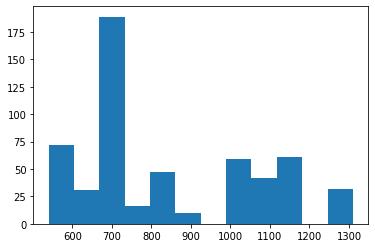

In [92]:
plt.hist(filter_data.Time, bins = 12)
plt.show()

## 3.	How Large Hubs compare to Medium hubs in terms of count of delayed flights. Use appropriate visualization to represent your findings.

In [93]:
combined_data_pax.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0,short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2713843.0,25001762.0,1934.0,short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,24728361.0,21905309.0,1934.0,short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2723002.0,21905309.0,1934.0,short


<AxesSubplot:xlabel='type_source_airport'>

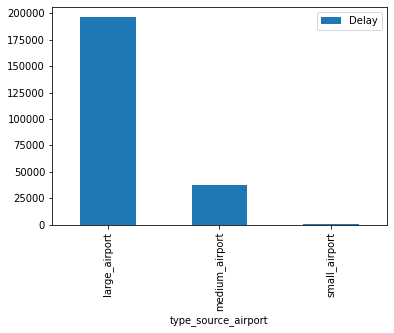

In [94]:
combined_data_pax.groupby('type_source_airport')[['Delay']].agg('sum').plot.bar()

<AxesSubplot:xlabel='type_dest_airport'>

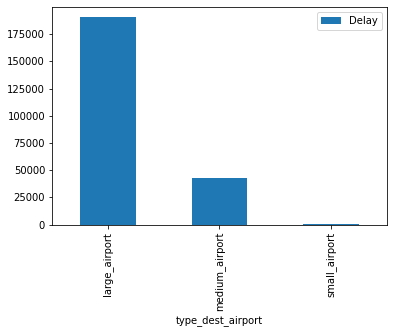

In [95]:
combined_data_pax.groupby('type_dest_airport')[['Delay']].agg('sum').plot.bar()

# 4.	For Large hubs, forecast the number of passengers for 2022 using simple moving average method.

In [96]:
# develop the series 

In [97]:
cols = ['iatacode'] + final_hub_data.columns[ final_hub_data.columns.str.startswith('data_')].tolist()


In [98]:
time_series = final_hub_data.loc[final_hub_data.hub_type == 'large', cols].set_index('iatacode').T

In [99]:
time_series['ATL']

data_2021    36676010.0
data_2020    20559866.0
data_2019    53505795.0
data_2018    51865797.0
data_2017    50251964.0
data_2016    50501858.0
data_2015    49340732.0
data_2014    46604273.0
data_2013    45308407.0
data_2012    45798928.0
data_2011    44414121.0
Name: ATL, dtype: float64

In [100]:
# there are 28 series with 11 values each 


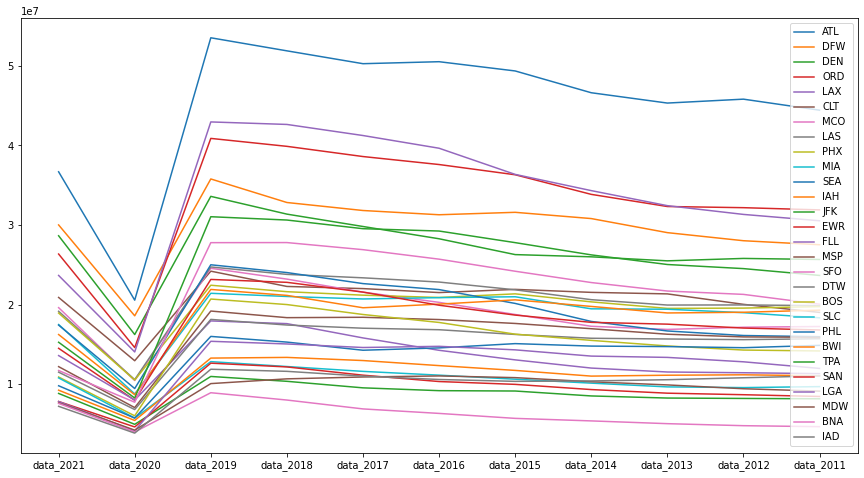

In [101]:
plt.figure(figsize = (15,8))
for ser in time_series.columns:
    plt.plot(time_series[ser], label = ser)
    plt.legend()
plt.show(block = True)

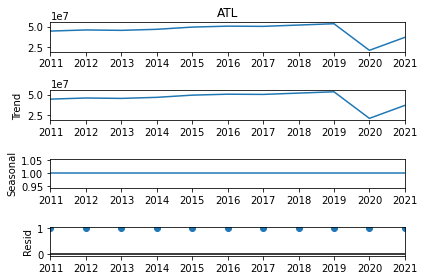

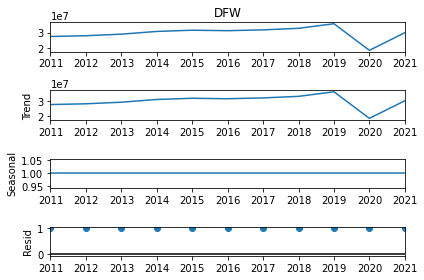

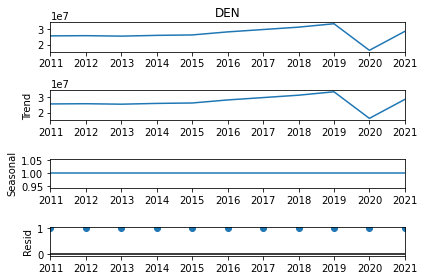

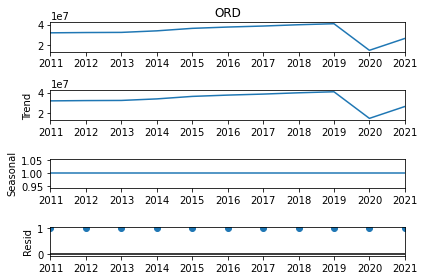

In [102]:
for ser in time_series.columns[:4]:
    series = time_series[ser].copy()
    series.index = pd.to_datetime(series.index.str.replace('data_',''))
    series.sort_index(inplace = True)
    decomposition = sm.tsa.seasonal_decompose(series, model='multiplicative') 
    decomposition.plot()
plt.show()

In [103]:
error = {}
forecast_2022 = {}
f = {}
wind_min = {}
win_min_mape = {}
for ser in time_series.columns:
    series = time_series[ser].copy()
    series.index = pd.to_datetime(series.index.str.replace('data_',''))
    series.sort_index(inplace = True)
    test = series[-1:]
    train = series[:-1]
    err_temp = {}
    fore_2022 = {}
    for window in range(2,10):
        forecast = series.rolling(window).mean()
        # accuracy 
        mape = round(mean_absolute_percentage_error(test, forecast[-1:]),4)
        err_temp.update({window : mape})
        # forecast for 2022
        fore_2022.update({window : series[-window:].mean()})
    err_ser = pd.Series(err_temp)
    min_wind = err_ser[(err_ser == err_ser.min())].index.values[0]
    forecast_2022.update({ser : round(series[-min_wind:].mean(),2)})
    wind_min.update({ser : min_wind})
    win_min_mape.update({ser :err_temp[min_wind] })
    f.update({ser :pd.Series(fore_2022).round(2) })
    error.update({ser : err_ser})
    
    # forecast for 2022


In [104]:
win_min_mape

{'ATL': 0.0065,
 'DFW': 0.0015,
 'DEN': 0.023,
 'ORD': 0.0351,
 'LAX': 0.1362,
 'CLT': 0.0006,
 'MCO': 0.0077,
 'LAS': 0.0212,
 'PHX': 0.0001,
 'MIA': 0.0182,
 'SEA': 0.0076,
 'IAH': 0.0389,
 'JFK': 0.1912,
 'EWR': 0.0486,
 'FLL': 0.0122,
 'MSP': 0.0502,
 'SFO': 0.1697,
 'DTW': 0.0559,
 'BOS': 0.1502,
 'SLC': 0.0062,
 'PHL': 0.0727,
 'BWI': 0.0082,
 'TPA': 0.0029,
 'SAN': 0.0686,
 'LGA': 0.1655,
 'MDW': 0.0453,
 'BNA': 0.0598,
 'IAD': 0.0595}

In [105]:
sma_forecast = pd.DataFrame(f)
sma_error = pd.DataFrame(error)

In [106]:
sma_prediction = pd.DataFrame(forecast_2022.values(), index = forecast_2022.keys(), columns = ['forecast_2022'] )
sma_prediction['window_used'] = wind_min.values()
sma_prediction['mape_at_window'] = win_min_mape.values()

In [107]:
sma_prediction

,forecast_2022,window_used,mape_at_window
ATL,36913890.33,3,0.0065
DFW,30049928.50,6,0.0015
DEN,27986853.33,6,0.0230
ORD,27276077.67,3,0.0351
LAX,26886097.00,3,0.1362
CLT,20913675.38,8,0.0006
MCO,19467356.50,8,0.0077
LAS,19566943.50,4,0.0212
PHX,18942662.60,5,0.0001
MIA,17182193.50,4,0.0182


5.	Perform hypothesis testing techniques to learn:

    I.	Has the altitude of the airport anything to do with flight delays. Check for incoming and outgoing flights
    II.	Has surface-type of runways of airports anything to do with flight delays
    III.	 Has length, duration of flight, anything to do with flight delays


# I.	Has the altitude of the airport anything to do with flight delays. Check for incoming and outgoing flights

# 2 sample t test 

# for outgoing

In [108]:
sample1 = combined_data_pax[combined_data_pax.Delay == 1].elevation_ft_source_airport
sample2 = combined_data_pax[combined_data_pax.Delay == 0].elevation_ft_source_airport

In [109]:
t, p = stats.ttest_ind(sample1, sample2)

In [110]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'

In [111]:
result

'reject null'

## for incoming flights

In [112]:
sample1 = combined_data_pax[combined_data_pax.Delay == 1].elevation_ft_dest_airport
sample2 = combined_data_pax[combined_data_pax.Delay == 0].elevation_ft_dest_airport

In [113]:
t, p = stats.ttest_ind(sample1, sample2)

In [114]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'

In [115]:
result

'reject null'

## Conclusion : Significant difference in avg elevation wrt flight delay for both incoming and outgoing flights

## is no. of runway at airport for delayed < for non delayed 

In [116]:
combined_data_pax

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0,short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2713843.0,25001762.0,1934.0,short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,24728361.0,21905309.0,1934.0,short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2723002.0,21905309.0,1934.0,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518551,538750,WN,2601,LAS,SMF,5,1230,85,1,large_airport,2181.0,4.0,large_airport,27.0,2.0,24728361.0,6454413.0,1967.0,short
518552,538783,WN,1936,SMF,SAN,5,1235,85,1,large_airport,27.0,2.0,large_airport,17.0,1.0,6454413.0,12648692.0,1967.0,short
518553,538810,WN,2629,LAS,RNO,5,1240,75,1,large_airport,2181.0,4.0,large_airport,4415.0,3.0,24728361.0,2162250.0,1967.0,short
518554,538833,WN,1226,SFO,LAX,5,1245,75,1,large_airport,13.0,4.0,large_airport,125.0,4.0,27779230.0,42939104.0,1967.0,short


In [117]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].runway_count_source_airport
s2 = combined_data_pax[combined_data_pax.Delay == 0].runway_count_source_airport

In [118]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [119]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].runway_count_dest_airport
s2 = combined_data_pax[combined_data_pax.Delay == 0].runway_count_dest_airport

In [120]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [121]:
combined_data_pax.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'data_2019_source_airport',
       'data_2019_dest_airport', 'Founded', 'duration'],
      dtype='object')

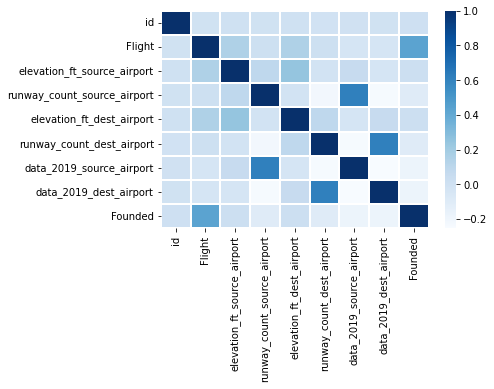

In [122]:
# Find correlation matrix amongst predictors of flight delay. Create a heatmap to visualize. Share your findings.

correlation_matix = combined_data_pax.drop(columns = ['DayOfWeek', 'Time', 'Length', 'Delay','type_source_airport','type_dest_airport']).corr()

sns.heatmap(correlation_matix, cmap='Blues',linecolor='white', linewidths=2)
plt.show()

## Conclusion : avg runway count at destination airport for delayed filghts < avg runway count at destination airport for delayed filghts for Incoming flights

## Has length, duration of flight, anything to do with flight delays!

In [123]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].Length
s2 = combined_data_pax[combined_data_pax.Delay == 0].Length

In [124]:
t, p = stats.ttest_ind(s1, s2)

In [125]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [126]:
# there is isgnificant difference

In [127]:
cs = pd.crosstab(combined_data_pax.duration, combined_data_pax.Delay)
cs

Delay,0,1
duration,,
short,255324,204474
medium,28991,29208
long,252,307


In [128]:
chi, p, df, ex = stats.chi2_contingency(cs)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [129]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


### Conclusion : avg duration for delayed filghts and non Delayed flights are significantly different.
        - avg duration of flights is less for non delayed flights
        - short duration flights get delayed less. 

## check info of dat

In [130]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0,short


In [131]:
combined_data_pax.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'data_2019_source_airport',
       'data_2019_dest_airport', 'Founded', 'duration'],
      dtype='object')

In [132]:
combined_data_pax.to_csv('combined_data_pax.csv', index=False)

## 7.	Use Onehotencoder and Ordinalencoder to deal with categorical variables.

In [133]:
combined_data_pax.isna().sum()

id                                0
Airline                           0
Flight                            0
AirportFrom                       0
AirportTo                         0
DayOfWeek                         0
Time                              0
Length                            0
Delay                             0
type_source_airport               0
elevation_ft_source_airport       0
runway_count_source_airport       0
type_dest_airport                 0
elevation_ft_dest_airport         0
runway_count_dest_airport         0
data_2019_source_airport       1173
data_2019_dest_airport         1166
Founded                           0
duration                          0
dtype: int64

In [134]:
combined_data_pax.dropna(inplace = True)

In [135]:
combined_data_pax.drop(columns = ['id', 'Flight',  'duration'], inplace = True)

In [136]:
combined_data_pax.head(2)

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded
0,CO,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,27779230.0,21905309.0,1934.0
1,CO,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,42939104.0,21905309.0,1934.0


In [137]:
combined_data_pax.type_dest_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [138]:
ordinal = OrdinalEncoder(categories=[['medium_airport', 'large_airport'],['medium_airport', 'large_airport']])
ordinal.fit(combined_data_pax[['type_source_airport', 'type_dest_airport']])

OrdinalEncoder(categories=[['medium_airport', 'large_airport'],
                           ['medium_airport', 'large_airport']])

In [139]:
combined_data_pax[['type_source_airport', 'type_dest_airport']] = ordinal.transform(combined_data_pax[['type_source_airport', 'type_dest_airport']])

In [140]:
model_data = combined_data_pax.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])

In [141]:
model_data.shape

(516217, 13)

In [142]:
dummy = pd.get_dummies(model_data)
dummy.shape

(516217, 13)

In [143]:
airlines.shape

(518556, 9)

In [144]:
dummy.Founded = 2022 - dummy.Founded

In [145]:
dummy.head(2)

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2019_source_airport,data_2019_dest_airport,Founded
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,27779230.0,21905309.0,88.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,42939104.0,21905309.0,88.0


In [146]:
model_data.reset_index(drop = True, inplace = True)

In [147]:
np.random.seed(12)
deploy_idx = np.random.choice(model_data.index, replace = False, size = 5000)

In [148]:
deploy = model_data.loc[deploy_idx]

In [149]:
X_deploy = deploy.drop(columns = 'Delay')

In [150]:
model_dev = model_data.loc[~model_data.index.isin(deploy.index)]

In [151]:
deploy.reset_index(drop = True, inplace = True)
model_dev.reset_index(drop = True, inplace = True)

In [152]:
X = model_dev.drop(columns = 'Delay')
y = model_dev.Delay

In [153]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
accuracy_train = {}
accuracy_test = {}
final_predictions_sgd = {}
i = 1
for train_index, test_index in folds.split(X,y):
    print('iter ', i)
    train, test = model_dev.loc[train_index,], model_dev.loc[test_index,]
    sc = StandardScaler()
    sgd = SGDClassifier()
    
    # define search space
    
    space = dict()
    space['sgd__penalty'] = ['l1', 'l2', 'elasticnet']
    space['sgd__l1_ratio'] = [0,.1,.2,.8,1]
    space['sgd__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000,10000] 
    space['sgd__learning_rate'] = ['constant', 'adaptive'] 
    space['sgd__eta0']=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1 , 2e-1, 3e-1, 5e-1, 8e-1, 4e-1, 8e-1, 1, 10, 100] 
    
    pipe = Pipeline([('sc',sc), ('sgd', sgd)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='accuracy', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    X_train = train.drop(columns = 'Delay')
    y_train = train.Delay
    
    result = search.fit(X_train, y_train)

    train_pred = result.predict(X_train)
    
    X_test = test.drop(columns = 'Delay')
    y_test = test.Delay
    test_pred = result.predict(X_test)
    final_predictions_sgd.update({'Fold{}'.format(i):result.predict(X_deploy)})
    
    # get rmse for each fold for train data 
    accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_train, y_pred = train_pred)*100,3)})
    accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_test, y_pred = test_pred) * 100,3)})
    i += 1

iter  1
iter  2
iter  3
iter  4
iter  5


In [154]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
dt_accuracy_train = {}
dt_accuracy_test = {}
final_predictions_dt = {}
i = 1
for train_index, test_index in folds.split(X,y):
    print('iter ', i)
    
    train, test = model_dev.loc[train_index,], model_dev.loc[test_index,]
    
    sc = StandardScaler()
    dt = DecisionTreeClassifier()
    
    
    # define search space
    space = dict()
    space['dt__min_samples_split'] = [25000, 30000, 35000, 40000, 45000, 50000, 60000 ]
    space['dt__min_samples_leaf'] = [10000, 15000, 20000]
    
    pipe = Pipeline([('sc',sc), ('dt', dt)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='accuracy', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    X_train = train.drop(columns = 'Delay')
    y_train = train.Delay
    
    result = search.fit(X_train, y_train)

    train_pred = result.predict(X_train)
    
    X_test = test.drop(columns = 'Delay')
    y_test = test.Delay
    test_pred = result.predict(X_test)
    final_predictions_dt.update({'Fold{}'.format(i):result.predict(X_deploy)})
    
    # get rmse for each fold for train data 
    dt_accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_train, y_pred = train_pred)*100,3)})
    dt_accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_test, y_pred = test_pred) * 100,3)})
    i += 1

iter  1
iter  2
iter  3
iter  4
iter  5


In [155]:
# compare results : 
train_results = pd.DataFrame ({'sgd' : accuracy_train.values(), 'dt': dt_accuracy_train.values() },
                             index = ['Fold {}'.format(i) for i in range(1,6)])
train_results

,sgd,dt
Fold 1,57.103,62.149
Fold 2,57.134,61.945
Fold 3,57.070,62.041
Fold 4,47.679,62.123
Fold 5,57.121,61.940


In [156]:
test_results = pd.DataFrame ({'sgd' : accuracy_test.values(), 'dt': dt_accuracy_test.values() },
                             index = ['Fold {}'.format(i) for i in range(1,6)])
test_results

,sgd,dt
Fold 1,57.074,62.145
Fold 2,57.032,61.773
Fold 3,57.199,62.248
Fold 4,47.829,61.918
Fold 5,57.045,62.019


# getting accuracies for final predictions

In [157]:
final_predictions_dt

{'Fold1': array([1, 0, 0, ..., 1, 0, 0]),
 'Fold2': array([0, 0, 0, ..., 0, 0, 0]),
 'Fold3': array([1, 0, 0, ..., 1, 0, 0]),
 'Fold4': array([1, 0, 0, ..., 1, 0, 0]),
 'Fold5': array([0, 0, 0, ..., 0, 0, 0])}

In [158]:
final_predictions_sgd

{'Fold1': array([1, 0, 0, ..., 0, 0, 0]),
 'Fold2': array([1, 0, 0, ..., 0, 0, 0]),
 'Fold3': array([0, 0, 0, ..., 0, 0, 0]),
 'Fold4': array([0, 1, 0, ..., 0, 1, 1]),
 'Fold5': array([0, 0, 0, ..., 0, 0, 0])}

In [159]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
xgb_accuracy_train = {}
xgb_accuracy_test = {}
final_predictions_xgb = []

i = 1
for train_index, test_index in folds.split(X,y):
    print('iter ', i)
    train, test = model_dev.loc[train_index,], model_dev.loc[test_index,]
    sc = StandardScaler()
    xgb_r = XGBClassifier(random_state = 12, use_label_encoder = False)

    # define search space
    space = dict()
    space['xgb_r__n_estimators'] = [40,50,60]
    space['xgb_r__max_depth'] = [3,4,5]
    space['xgb_r__colsample_bytree']:[0.4,.5,.6]
    space['xgb_r__lambda'] = [.0001,.002,.0004,.0003]
    space['xgb_r__alpha'] = [.01,.02,.1,.4]
    
    pipe = Pipeline([('sc',sc), ('xgb_r', xgb_r)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='neg_root_mean_squared_error', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    X_train = train.drop(columns = 'Delay')
    y_train = train.Delay
    
    result = search.fit(X_train, y_train)

    train_pred = result.predict(X_train)
    
    X_test = test.drop(columns = 'Delay')
    y_test = test.Delay
    test_pred = result.predict(X_test)
    
    final_predictions_xgb.append(result.predict(X_deploy))  
    
    # get rmse for each fold for train data 
    xgb_accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_train, y_pred = train_pred),3)})
    xgb_accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = y_test, y_pred = test_pred),3)})
    i += 1

iter  1


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


iter  2
iter  3
iter  4
iter  5


In [160]:
xgb_accuracy_train

{'Fold1': 0.64, 'Fold2': 0.647, 'Fold3': 0.647, 'Fold4': 0.646, 'Fold5': 0.647}

In [161]:
xgb_accuracy_train.values()

dict_values([0.64, 0.647, 0.647, 0.646, 0.647])

In [162]:
train_results['xgb'] = xgb_accuracy_train.values()
test_results['xgb'] = xgb_accuracy_test.values()

In [163]:
train_results

,sgd,dt,xgb
Fold 1,57.103,62.149,0.640
Fold 2,57.134,61.945,0.647
Fold 3,57.070,62.041,0.647
Fold 4,47.679,62.123,0.646
Fold 5,57.121,61.940,0.647


In [164]:
test_results

,sgd,dt,xgb
Fold 1,57.074,62.145,0.639
Fold 2,57.032,61.773,0.644
Fold 3,57.199,62.248,0.645
Fold 4,47.829,61.918,0.644
Fold 5,57.045,62.019,0.644
